**Práctica 9: Pronósticos con statsmodels**
    
Para practicar el arte de pronosticar, es decir, predecir un valor que tomará una variable a partir de valores que haya tomado en la anterioridad, vamos a intentar a pronosticar la calificación de primera y segunda oportunidad de los alumnos de mates discretas de Elisa a partir de sus calificaciones de
* tareas 1, 2, 3, 4 y 5
* examen de medio curso
* proyecto integrador
pero _sin_ conocer el resultado de examen ordinariocuando pronosticamos la calificación de primera oportunidad, aunque sí se incluye cuando se pronostica la de *segunda* oportunidad para los que no pasaron en primera.

Hay un archivo CSV con esta información sobre 74 alumnos, digitalizado en algún momento sin anotar de qué semestre es. Vamos a normalizar todos los resultados a que estén entre cero y uno, descartando la columna que contiene la suma de las tareas igual como la de puntos extra por portafolio de evidencia.

Habrá que combinarlo primero con los resultados de los exámenes correspondientes para contar con esa información también. Esos los tenemos en resultados.txt (que no les voy a compartir por contener las matrículas completas).

In [ ]:
d = dict()

with open('completos.csv') as data:
    header = data.readline()
    for line in data:
        tokens = line.strip().split(',')
        d[tokens.pop(0)] = tokens

with open('../resultados.txt') as data:
    header = data.readline()
    for line in data:
        tokens = line.strip().split()
        sem = tokens.pop(0)
        suffix = tokens.pop(0)[-4:]
        if suffix in d:
            print(sem, ' '.join([str(t) for t in d[suffix]]), ' '.join([str(t) for t in tokens]))

In [ ]:
python3 combine.py | head -n 3
ej17 M4 10 10 10 10 10 50 4 0 70 NA 0 4.0 12.0 4.0 NP
ej17 M4 10 10 10 10 10 50 5 1 75 NA 0 6.0 12.5 5.0 1.0
ej17 M4 10 4 8 4 4 30 0 0 43 NA 1 4.0 8.5 NP NP

Pinta que son de ej17. Hay que verificar que _todos_ sean de ese semestre y que no haya un sufijo que se haya duplicado en otro semestre.

In [ ]:
python3 combine.py | awk 'BEGIN{otro = 0}{if ($1 != "ej17") {otro++}}END{print otro}'
0
python3 combine.py > completos.dat

In [12]:
import pandas as pd
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/completos.dat", sep=" ", header = None)
d.columns = ['Sem', 'Gr', 'T1', 'T2', 'T3', 'T4', 'T5', 'Suma', 'Proy', 'Port', 'CF1ra', 'CF2da', 'NPs', \
             'mc', 'eo', 'pr', 'pf']        
print(d.dtypes)
d.T1 = d.T1 / 10 # tareas valen máximo 10
d.T2 = d.T2 / 10
d.T3 = d.T3 / 10
d.T4 = d.T4 / 10
d.T5 = d.T5 / 10
d.Proy = d.Proy / 10 # igual el proyecto
d.CF1ra = d.CF1ra.replace('NP', 0) / 100 # vamos a tratar a los NPs como cero puntos
d.CF2da = d.CF2da.replace('NP', 0) 
d.CF2da = d.CF2da.replace('NC', 0) # los NCs también corresponden a cero puntos
d.CF2da = d.CF2da.replace('NA', 0) / 100
d.mc = pd.to_numeric(d.mc.replace('NP', 0)) / 20 # exámenes valen 20
d.eo = pd.to_numeric(d.eo.replace('NP', 0)) / 20
d.NPs = d.NPs / 8 # son cinco tareas, un proyecto y dos exámenes, es decir, ocho actividades 
d.pr = pd.to_numeric(d.pr.replace('NP', 0))
d.pf = pd.to_numeric(d.pf.replace('NP', 0))
d.Proy.corr(pd.to_numeric(d.pr) / 10) # deberían ser esencialmente los mismos puntos
d.Port.corr(pd.to_numeric(d.pf))
d = d.drop(['Sem', 'Suma','Port', 'pf', 'pr'], axis = 1)
for c in d.columns:
    col = d[c]
    print(col.min(), col.max(), col.dtype)

Sem      object
Gr       object
T1        int64
T2        int64
T3        int64
T4        int64
T5        int64
Suma      int64
Proy      int64
Port      int64
CF1ra     int64
CF2da    object
NPs       int64
mc       object
eo       object
pr       object
pf       object
dtype: object
M4 V4 object
0.6 1.0 float64
0.4 1.0 float64
0.0 1.0 float64
0.0 1.0 float64
0.0 1.0 float64
0.0 0.7 float64
0.14 0.87 float64
0.0 0.0 float64
0.0 0.625 float64
0.0 0.6 float64
0.0 0.8 float64


OK, ya son todas las columnas normalizadas y numéricas. Habrá que ordenarlas para que reflejen el transcurso del semestre: el examen de medio curso se presenta antes de la tercera tarea.

T1       1.0
T2       1.0
mc       0.2
T3       1.0
T4       1.0
T5       1.0
Proy     0.4
eo       0.6
CF1ra    0.7
CF2da    0.0
Name: 0, dtype: float64


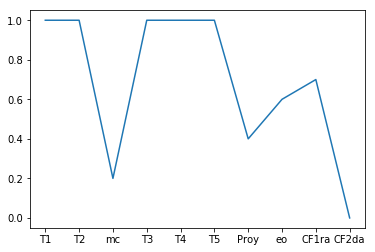

In [29]:
import matplotlib.pyplot as plt
from numpy import asarray
import pandas as pd
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/completos.dat", sep=" ", header = None)
d.columns = ['Sem', 'Gr', 'T1', 'T2', 'T3', 'T4', 'T5', 'Suma', 'Proy', 'Port', 'CF1ra', 'CF2da', 'NPs', \
             'mc', 'eo', 'pr', 'pf']        
d.T1 = d.T1 / 10 # tareas valen máximo 10
d.T2 = d.T2 / 10
d.T3 = d.T3 / 10
d.T4 = d.T4 / 10
d.T5 = d.T5 / 10
d.Proy = d.Proy / 10 # igual el proyecto
d.CF1ra = d.CF1ra.replace('NP', 0) / 100
d.CF2da = d.CF2da.replace('NP', 0) 
d.CF2da = d.CF2da.replace('NC', 0) 
d.CF2da = d.CF2da.replace(NaN, 0) / 10 # las NA se interpretaron como NaN
d.mc = pd.to_numeric(d.mc.replace('NP', 0)) / 20 # exámenes valen 20
d.eo = pd.to_numeric(d.eo.replace('NP', 0)) / 20
d.NPs = d.NPs / 8 # son cinco tareas, un proyecto y dos exámenes, es decir, ocho actividades 
d = d[['T1', 'T2', 'mc', 'T3', 'T4', 'T5', 'Proy', 'eo', 'CF1ra', 'CF2da']]
ejemplo = d.loc[0,:]
print(ejemplo)
x = range(len(ejemplo))
plt.plot(x, asarray(ejemplo))
plt.xticks(x, ejemplo.index)
plt.show()

La serie es algo corta y algo fea, pero veremos qué podemos pronosticar con el método de Holt.

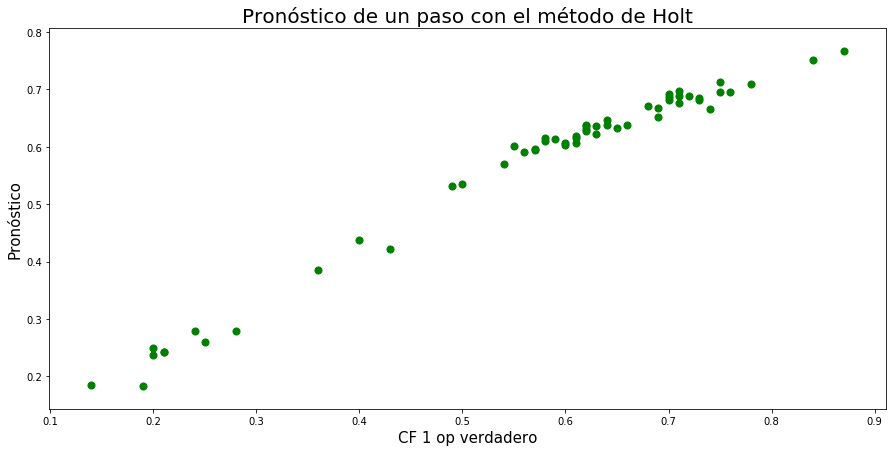

In [144]:
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt
from numpy import asarray
import pandas as pd
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/completos.dat", sep=" ", header = None)
d.columns = ['Sem', 'Gr', 'T1', 'T2', 'T3', 'T4', 'T5', 'Suma', 'Proy', 'Port', 'CF1ra', 'CF2da', 'NPs', \
             'mc', 'eo', 'pr', 'pf']        
d.T1 = d.T1 / 10 # tareas valen máximo 10
d.T2 = d.T2 / 10
d.T3 = d.T3 / 10
d.T4 = d.T4 / 10
d.T5 = d.T5 / 10
d.Proy = d.Proy / 10 # igual el proyecto
d.CF1ra = d.CF1ra.replace('NP', 0) / 100
d.CF2da = d.CF2da.replace('NP', 0) 
d.CF2da = d.CF2da.replace('NC', 0) 
d.CF2da = d.CF2da.replace(NaN, 0) / 10 # las NA se interpretaron como NaN
d.mc = pd.to_numeric(d.mc.replace('NP', 0)) / 20 # exámenes valen 20
d.eo = pd.to_numeric(d.eo.replace('NP', 0)) / 20
d.NPs = d.NPs / 8 # son cinco tareas, un proyecto y dos exámenes, es decir, ocho actividades 
d = d[['T1', 'T2', 'mc', 'T3', 'T4', 'T5', 'Proy', 'eo', 'CF1ra', 'CF2da']]
lbls = d.columns
x = range(len(lbls))
pronosticos = []
for i in range(len(d)):
    y = asarray(d.loc[i,:])
    f = Holt(asarray(y)).fit(smoothing_level = 0.1)
    pronosticos.append(f.forecast(1))
plt.title('Pronóstico de un paso con el método de Holt', fontsize = 20)
plt.xlabel('CF 1 op verdadero', fontsize = 15)
plt.ylabel('Pronóstico', fontsize = 15)
plt.scatter(d.CF1ra, pronosticos, c = 'g', s = 50)
plt.show()

Se nota que el pronóstico siempre es menor que el valor correcto, pero por lo menos están fuertemente correlacionados. 

Para probar métodos más sofisticados, quedan demasiado breves las series de tiempo del caso de estudio de alumnos. Usemos otros datos para unos ejemplos adicionales: datos de números de casos semanales reportados de infecciones respitarorias agudas en tres estados méxicanos y el total federal por 89 semanas epidemiologicas, desde mediados del 2014 hasta inicios de 2016 (los datos en sí provienen del [boletín](https://www.gob.mx/salud/acciones-y-programas/direccion-general-de-epidemiologia-boletin-epidemiologico) de la DGE.

Será nuestra entrada ejemplo a un modelo __[ARIMA](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)__ (promedios deslizantes autoregresivos, por auto-regressive integrated moving average en inglés).

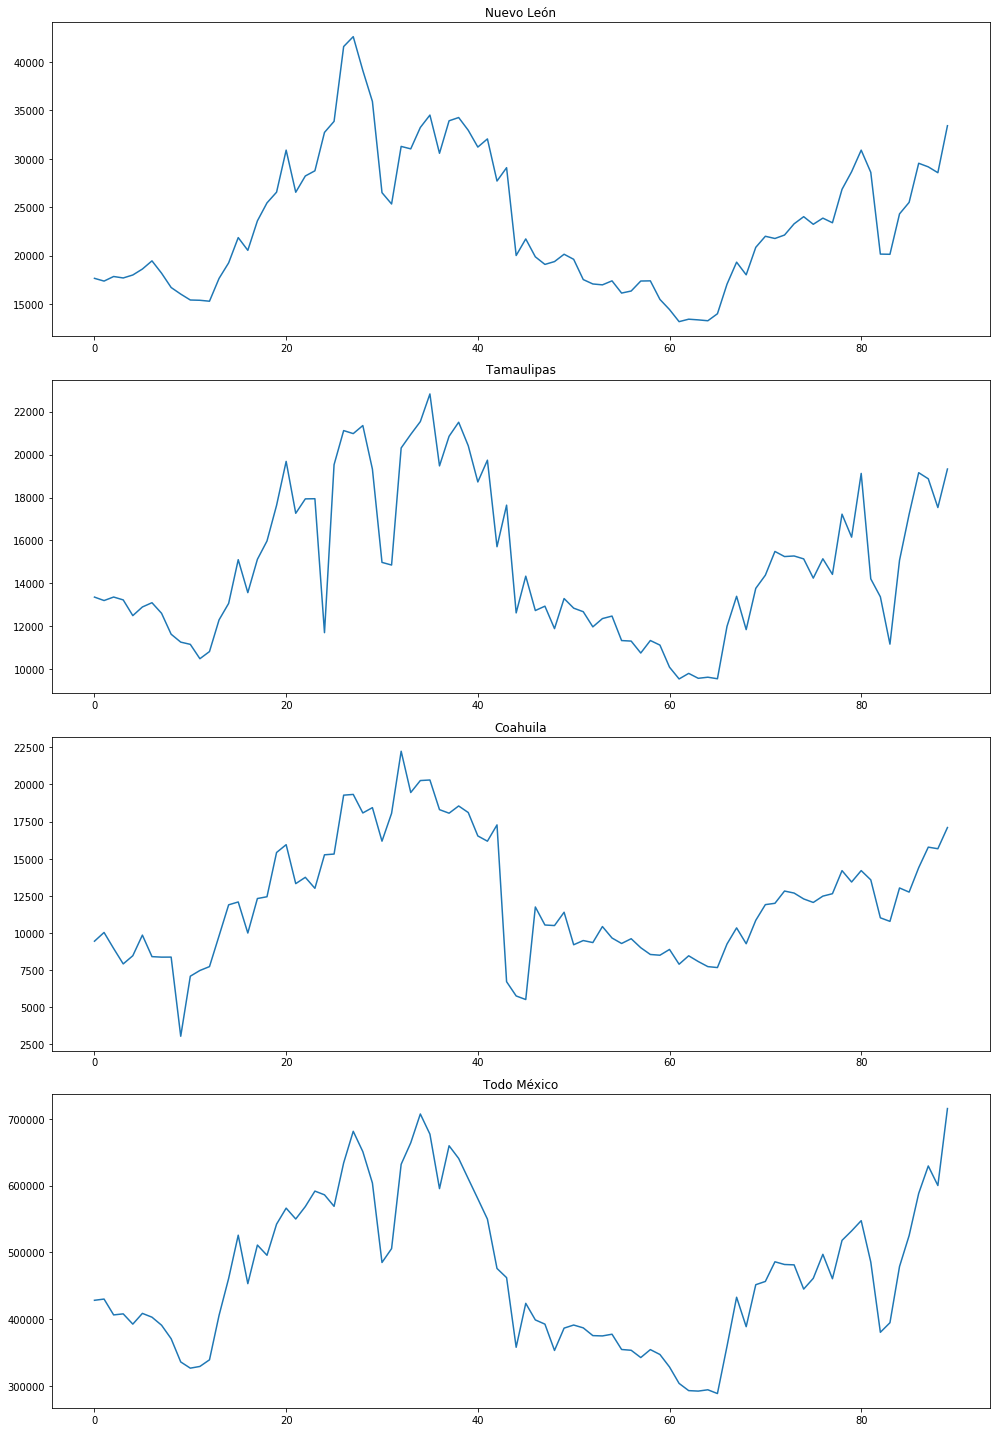

In [225]:
import matplotlib.pyplot as plt
from numpy import asarray
import pandas as pd
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
x = range(len(d))
lbls = ['{:d} {:d}'.format(s, a) for (s, a) in zip(d['SE'], d['A'])]
plt.rcParams["figure.figsize"] = [14, 20]
f = plt.figure() 
sf = f.add_subplot(411)
y = asarray(d['NL'])
sf.plot(x, y)
sf.set_title('Nuevo León')
sf = f.add_subplot(412)
y = asarray(d['Tamps'])
sf.set_title('Tamaulipas')
sf.plot(x, y)
sf = f.add_subplot(413)
y = asarray(d['Coa'])
sf.set_title('Coahuila')
sf.plot(x, y)
sf = f.add_subplot(414)
y = asarray(d['Federal'])
sf.set_title('Todo México')
sf.plot(x, y)
plt.tight_layout()
plt.show()

Se nota que tienen un periodo. Habrá que averiguar de cuántas semanas (tendría sentido que fuese un año, ya que infecciones respiratorias son afectadas por el clima).

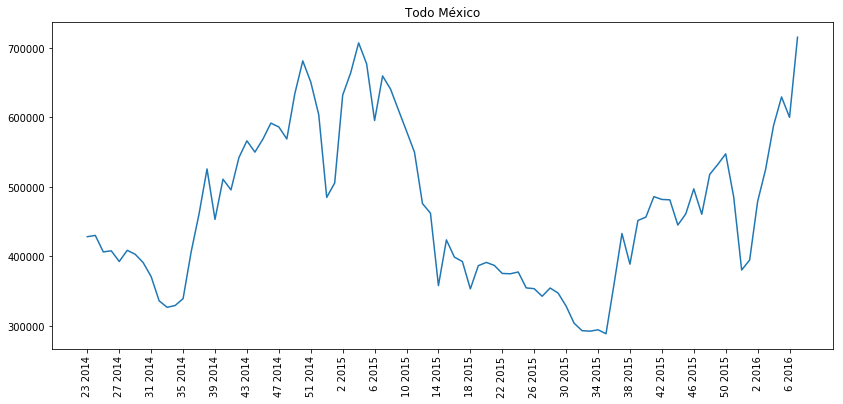

In [230]:
import matplotlib.pyplot as plt
from numpy import asarray
import pandas as pd
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
x = range(len(d))
lbls = ['{:d} {:d}'.format(s, a) for (s, a) in zip(d['SE'], d['A'])]
plt.rcParams["figure.figsize"] = [14, 6]
y = asarray(d['Federal'])
plt.title('Todo México')
plt.plot(x, y)
k = 4
plt.xticks(x[::k], lbls[::k], rotation = 90)
plt.show()

Pinta que el periodo estacional es de un año, es decir, 52 semanas.

Habrá que asegurar que las series son estacionarias, y para eso hay ya un código que nos sirve en un [tutorial](el [tutorial](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) por Aarshay Jain.
                                                                                                            

Results of Dickey-Fuller Test:
Test Statistic	-1.648
p-value	0.458
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584Results of Dickey-Fuller Test:
Test Statistic	-1.869
p-value	0.347
#Lags Used	7.000
Number of Observations Used	82.000
Critical Value (1%)	-3.513
Critical Value (5%)	-2.897
Critical Value (10%)	-2.586Results of Dickey-Fuller Test:
Test Statistic	-2.266
p-value	0.183
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584Results of Dickey-Fuller Test:
Test Statistic	-1.309
p-value	0.625
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584


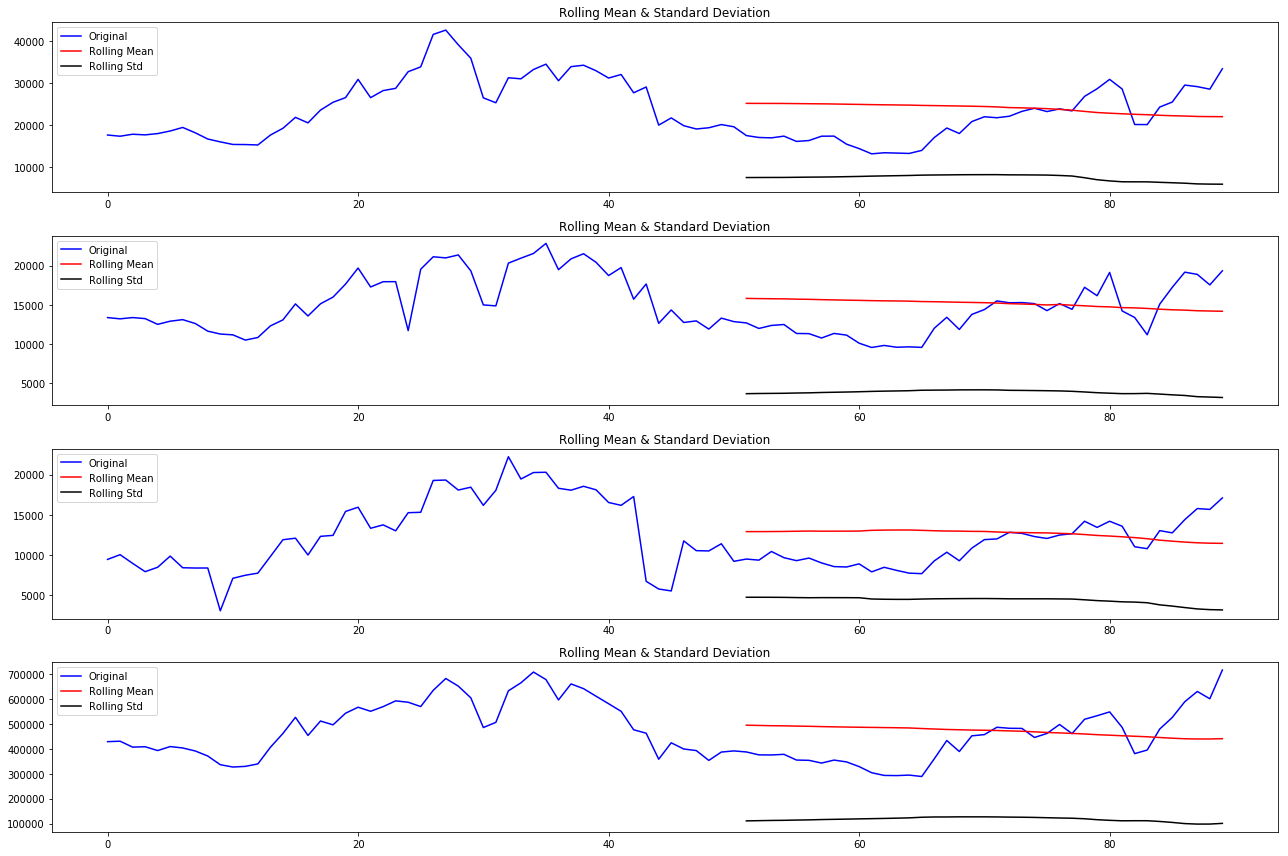

In [232]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import ssl

# rutina de https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
def test_stationarity(ts, w, r, i): 
    rolmean = ts.rolling(w).mean()
    rolstd = ts.rolling(w).std()
    plt.subplot(r, 1, i) 
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({:s})'.format(key)] = value
    return 'Results of Dickey-Fuller Test:\n' + '\n'.join(['{:s}\t{:.3f}'.format(k, v) for (k, v) in dfoutput.items()])

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
plt.rcParams["figure.figsize"] = [18, 12]
f = plt.figure()     
i = 1
lvls = ['NL', 'Tamps', 'Coa', 'Federal']
r = len(lvls)
t = ''
w = 52
for c in lvls:
    t += test_stationarity(d[c], w, r, i)
    i += 1
plt.tight_layout()
print(t)

Los valores p son tan grandes que no podemos descartar que haya tendencia. Además es obvio que contamos con estacionalidad: la curva roja oscila. Vamos a ver si un modelo de regresión lineal basta para quitar la tendencia.

Results of Dickey-Fuller Test:
Test Statistic	-1.649
p-value	0.458
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584Results of Dickey-Fuller Test:
Test Statistic	-1.866
p-value	0.348
#Lags Used	7.000
Number of Observations Used	82.000
Critical Value (1%)	-3.513
Critical Value (5%)	-2.897
Critical Value (10%)	-2.586Results of Dickey-Fuller Test:
Test Statistic	-2.278
p-value	0.179
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584Results of Dickey-Fuller Test:
Test Statistic	-1.297
p-value	0.631
#Lags Used	0.000
Number of Observations Used	89.000
Critical Value (1%)	-3.506
Critical Value (5%)	-2.895
Critical Value (10%)	-2.584


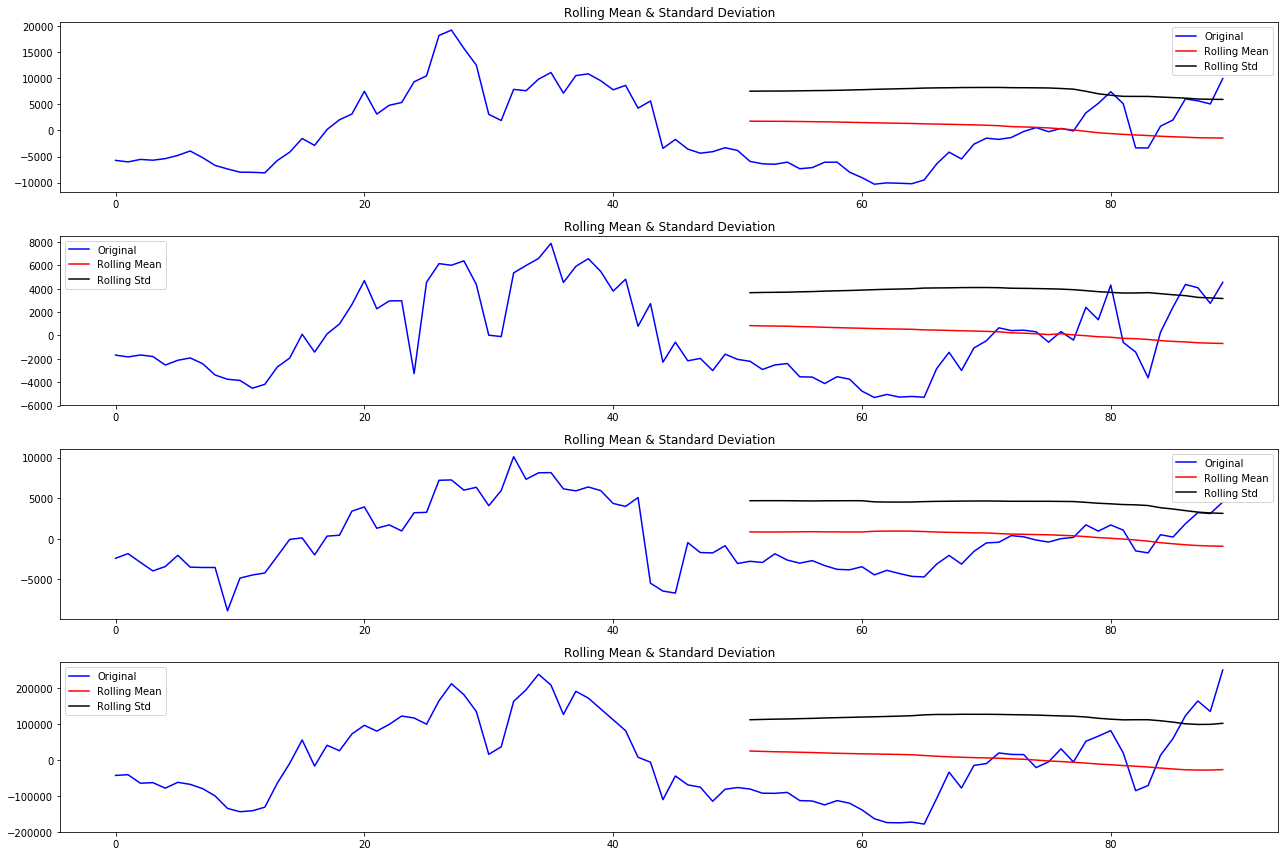

In [233]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy import stats
from numpy import asarray
import pandas as pd
import ssl

# rutina de https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
def test_stationarity(ts, w, r, i): 
    rolmean = ts.rolling(w).mean()
    rolstd = ts.rolling(w).std()
    plt.subplot(r, 1, i) 
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({:s})'.format(key)] = value
    return 'Results of Dickey-Fuller Test:\n' + '\n'.join(['{:s}\t{:.3f}'.format(k, v) for (k, v) in dfoutput.items()])

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')

plt.rcParams["figure.figsize"] = [18, 12]
f = plt.figure()     
lvls = ['NL', 'Tamps', 'Coa', 'Federal']
t = ''
n = len(d)
x = [i for i in range(n)]
i = 1
w = 52
for c in lvls:
    y = asarray(d[c])
    a, b, r, p, e = stats.linregress(x, y)
    m = [a * v + b for v in x] # valores del modelo lineal
    repl = c + 'v2'
    d[repl] = y - m # los restamos
    t += test_stationarity(d[repl], w, len(lvls), i)
    i += 1
plt.tight_layout()
print(t)

Como que no convence. Los valores p siguen claramente por encima de un nivel de significancia razonable. 

Intentemos *restando* de cada valor en valor correspondiente un año antes (hace 52 semanas), siguiendo [otro tutorial](https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/).

NL
ADF Stat	-1.819
p-value	0.371

	1%: -3.621
	5%: -2.944
	10%: -2.610
Tamps
ADF Stat	-5.944
p-value	0.000

	1%: -3.621
	5%: -2.944
	10%: -2.610
Coa
ADF Stat	-1.813
p-value	0.374

	1%: -3.621
	5%: -2.944
	10%: -2.610
Federal
ADF Stat	-2.151
p-value	0.225

	1%: -3.633
	5%: -2.949
	10%: -2.613


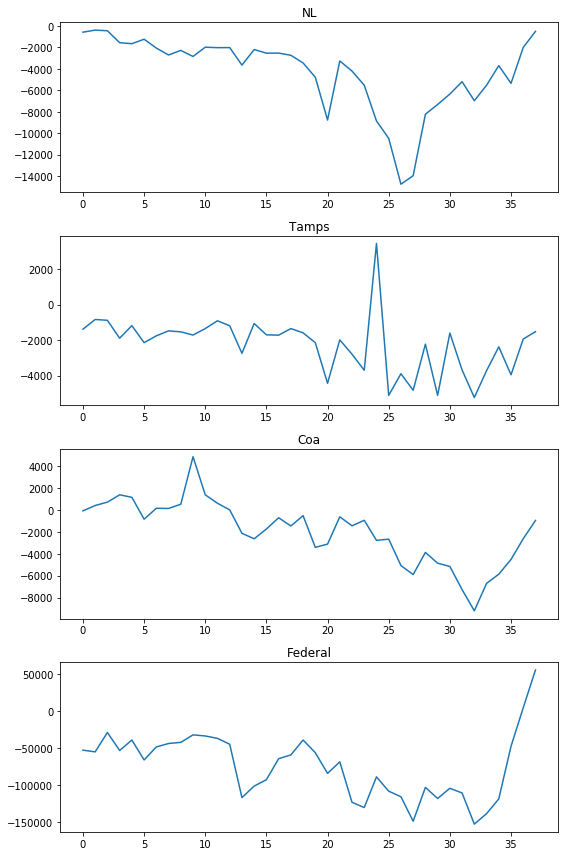

In [254]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas import Series
from numpy import asarray
import pandas as pd
import ssl

# de https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
plt.rcParams["figure.figsize"] = [8, 12]
f = plt.figure()  
i = 1
for c in ['NL', 'Tamps', 'Coa', 'Federal']:
    ts = difference(asarray(d[c]), interval = 52)
    ts = ts.dropna()
    plt.subplot(4, 1, i)
    plt.title(c)
    plt.plot(ts)
    i += 1
    result = adfuller(ts)
    print('{:s}\nADF Stat\t{:.3f}\np-value\t{:.3f}\n'.format(c, result[0], result[1]))
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
plt.tight_layout()

Tamaulipas ya quedó según la prueba estadística, aunque da dudas ese pico. Intentemos pronosticar así, de todas formas.

Los modelos ARIMA requieren múltiples parámetros y son muy sensibles a sus valores. Vamos a determinar valores adecuados a algunos siguiendo el [tutorial](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

Para saber qué tan bien pronosticamos, voy a quitar las última observación y comparar los resultados del pronóstico con los valores verdaderos.

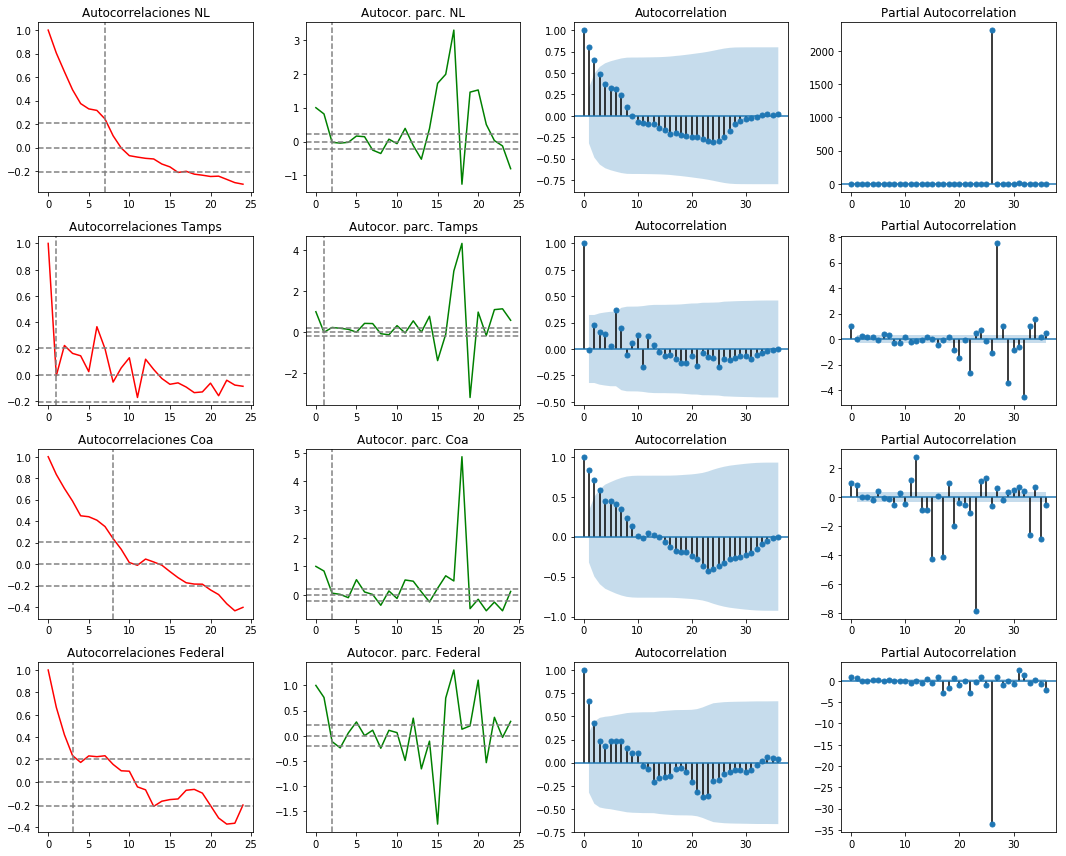

In [287]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import ssl

# de https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
d = d.iloc[:-1, :] # quitar uno
plt.rcParams["figure.figsize"] = [15, 12]
f = plt.figure()
i = 1
n = len(d)
q = {'NL': 7, 'Tamps': 1, 'Coa': 8, 'Federal': 3}
p = {'NL': 2, 'Tamps': 1, 'Coa': 2, 'Federal': 2}
for c in ['NL', 'Tamps', 'Coa', 'Federal']:
    ts = difference(asarray(d[c]), interval = 52).dropna()
    # manera del primer tutorial
    plt.subplot(4, 4, i)
    i += 1
    plt.plot(acf(ts, nlags = 24), 'r')
    plt.axhline(y = 0, linestyle='--', color = 'gray')
    plt.axvline(x = q[c], linestyle = '--', color='gray')
    plt.axhline(y = -1.96 / sqrt(n), linestyle = '--', color='gray')
    plt.axhline(y = 1.96 / sqrt(n), linestyle = '--', color='gray')
    plt.title('Autocorrelaciones ' + c)
    plt.subplot(4, 4, i)
    i += 1
    plt.plot(pacf(ts, nlags = 24, method='ols'), 'g')
    plt.axhline(y = 0, linestyle = '--', color = 'gray')
    plt.axvline(x = p[c], linestyle = '--', color='gray')
    plt.axhline(y = -1.96 / sqrt(n),linestyle = '--', color='gray')
    plt.axhline(y = 1.96 / sqrt(n),linestyle = '--', color='gray')
    plt.title('Autocor. parc. ' + c)
    # manera del segundo tutorial
    plt.subplot(4, 4, i)
    i += 1
    plot_acf(ts, ax = plt.gca())
    plt.subplot(4, 4, i)
    i += 1
    plot_pacf(ts, ax = plt.gca())
plt.tight_layout()

Entonces, siguiendo el procedimiento del primer tutorial, buscando la coordenada x del primer cruce con el intervalo de confianza superior, se obtiene
q = {'NL': 7, 'Tamps': 1, 'Coa': 8, 'Federal': 3}
p = {'NL': 2, 'Tamps': 1, 'Coa': 2, 'Federal': 2}

Con la lógica del segundo tutorial, además de Tamps, se ven mal todas las autocorrelaciones y además están horribles los picos en las parciales. 

Vamos a redondear los pronósticos al entero más cercano (cómo vas a tener 0.13 casos de una enfermadad, anyhow?)

In [344]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import ssl
 
# https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv('https://elisa.dyndns-web.com/teaching/comp/datasci/IRA.csv')
guardar = d.iloc[-1:, :]
d = d.iloc[:-1, :]
n = len(d)
q = {'NL': 1, 'Tamps': 1, 'Coa': 2, 'Federal': 1}
p = {'NL': 2, 'Tamps': 1, 'Coa': 2, 'Federal': 0}
prons = []
for c in ['NL', 'Tamps', 'Coa', 'Federal']:
    ts = difference(asarray(d[c]), interval = 52).dropna()
    try:
        m = ARIMA(ts, order = (p[c], 1, q[c])) 
        f = m.fit(trend = 'nc', disp = 0)
        print('{:s}\tpron.\t'.format(c), int(round(f.forecast()[0][0] + d[c].iloc[n - 52])))
        print('{:s}\treal\t'.format(c), guardar[c].iloc[0])
    except:
        print(c, "no se pudo pronosticar con esos parámetros")
    print('...')

NL	pron.	 31658
NL	real	 33422
...
Tamps	pron.	 17257
Tamps	real	 19330
...
Coa	pron.	 14437
Coa	real	 17099
...
Federal	pron.	 663234
Federal	real	 715298
...


Con mal portados que son los datos, los valores de p y q sacados de las gráficas no terminan en modelos matemáticamente bien definidos, por lo cual se tuvo que recurrir a ajuste manual.

Con datos más tratables con métodos de pronósticos, estaría padre ver cuántos valores se puede pronosticar antes de que el error crezca mucho y graficar en un color lo correcto y en otro lo pronosticado.

En el noveno reporte, busca por algo que se pueda pronosticar en tu propio caso de estudio, y si de plano no hay nada, busca algún otro fuente de datos públicamente disponibles para prácticas técnicas de pronóstico.